In [38]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pandas as pd
import numpy as np
import os
import re
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [39]:
Data = np.loadtxt('Data.txt')

In [40]:
X = Data[:,:-1]
X.shape

(36308, 12)

In [41]:
Y = Data[:,-1]
Y.shape

(36308,)

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=9, stratify=Y)

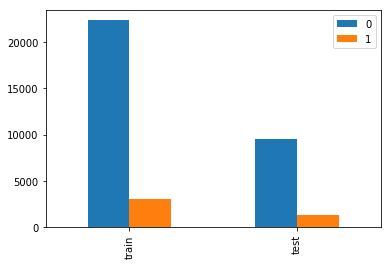

In [43]:
train_1 = (Y_train == 1).sum()
train_0 = (Y_train == 0).sum()
test_1 = (Y_test == 1).sum()
test_0 = (Y_test == 0).sum()
c = pd.DataFrame({'0':[train_0,test_0],'1':[train_1,test_1]},index = ['train', 'test'])
c.plot(kind = 'bar')
plt.show()

In [44]:
lr = LogisticRegression(C = 1000, tol = 1e-5, class_weight={0:1,1:4}, solver= 'saga', max_iter = 1000)

In [45]:
mlp = MLPClassifier(alpha=0.01, hidden_layer_sizes=(150, 60), max_iter=2000, random_state=9)

In [46]:
rf = RandomForestClassifier(n_estimators = 3000, oob_score = True, n_jobs = 3, random_state=9, class_weight='balanced',
                           max_depth=15, max_features=4, min_samples_split=80)

In [47]:
svc1 = svm.SVC(probability = True, class_weight = 'balanced', C=10000.0, degree=2, kernel='poly')

In [48]:
svc2 = svm.SVC(probability = True, class_weight = 'balanced', C=10000.0, gamma=0.01, kernel='rbf')

In [49]:
abc = AdaBoostClassifier(n_estimators=3000, random_state=9, learning_rate=0.02)

In [50]:
gbc = GradientBoostingClassifier(n_estimators = 3000, learning_rate=0.01, max_leaf_nodes=8, subsample=0.7)

In [51]:
lr_meta = LogisticRegression(C = 1000, tol = 1e-5, solver= 'saga', max_iter = 1000)

In [52]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=3):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict_proba(X[holdout_index])[:,1]
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict_proba(X)[:,1] for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
    
    def predict_proba(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict_proba(X)[:,1] for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict_proba(meta_features)

In [53]:
stacked_averaged_models = StackingAveragedModels(base_models = (lr, mlp, rf, svc1, svc2, abc, gbc),
                                                 meta_model = lr_meta)

In [54]:
stacked_averaged_models.fit(X_train,Y_train)

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    9.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   36.9s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:  5.2min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:  6.9min
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:  8.3min finished
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    6.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   14.3s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   25.5s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   40.1s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   58.0s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:  1.6min finis

StackingAveragedModels(base_models=(LogisticRegression(C=1000, class_weight={0: 1, 1: 4}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=1e-05, verbose=0, warm_start=False), MLPClassifier(act...       presort='auto', random_state=None, subsample=0.7, verbose=0,
              warm_start=False)),
            meta_model=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='saga', tol=1e-05,
          verbose=0, warm_start=False),
            n_folds=3)

In [55]:
joblib.dump(stacked_averaged_models, 'stack.pkl')

['stack.pkl']

In [56]:
clf = joblib.load( 'stack.pkl')

In [57]:
from sklearn.metrics import confusion_matrix

In [58]:
confusion_matrix(Y_train, clf.predict(X_train))

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    5.8s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   10.2s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   16.2s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   23.0s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:   31.0s
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:   38.1s finished
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:    9.9s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   15.4s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   22.2s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:   30.2s
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:   37.0s finis

array([[21941,   388],
       [ 1962,  1124]], dtype=int64)

In [59]:
confusion_matrix(Y_test, clf.predict(X_test))

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:    8.9s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   14.3s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   21.0s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:   28.3s
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:   34.6s finished
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    4.9s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:    8.7s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   13.6s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   19.7s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:   26.9s
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:   32.9s finis

array([[9355,  215],
       [ 871,  452]], dtype=int64)

In [60]:
from sklearn.metrics import classification_report

In [61]:
print(classification_report(Y_train, clf.predict(X_train)))

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    5.8s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   10.4s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   15.9s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   22.7s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:   30.7s
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:   37.4s finished
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:    9.9s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   15.8s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   22.5s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:   30.3s
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:   37.1s finis

             precision    recall  f1-score   support

        0.0       0.92      0.98      0.95     22329
        1.0       0.74      0.36      0.49      3086

avg / total       0.90      0.91      0.89     25415



In [62]:
print(classification_report(Y_test, clf.predict(X_test)))

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    5.8s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   10.3s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   16.1s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   22.9s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:   30.9s
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:   37.9s finished
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    5.4s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:    9.7s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   15.2s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   22.5s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:   30.7s
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:   37.4s finis

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.95      9570
        1.0       0.68      0.34      0.45      1323

avg / total       0.89      0.90      0.89     10893



In [63]:
from sklearn.metrics import roc_auc_score

In [64]:
roc_auc_score(Y_train, clf.predict_proba(X_train)[:,1],average = 'micro')

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    5.1s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:    9.1s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   14.3s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   20.8s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:   28.3s
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:   34.8s finished
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:    9.0s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   14.1s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   20.4s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:   27.7s
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:   34.1s finis

0.8985183992278089

In [65]:
roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1],average = 'micro')

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    6.2s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   11.3s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   17.5s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   25.0s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:   32.4s
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:   38.1s finished
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    1.9s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   10.4s
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:   16.7s
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:   23.4s
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:   30.1s
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed:   37.0s finis

0.8457183453899382